In [158]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from matplotlib import pyplot as plt
import geopandas as gpd

In [4]:
full_dataset = rasterio.open(r'C:\Users\CRISTIAN\OneDrive - Universidad de Alcala\Classificaciones\clipped_image_7b_ord.tif')

In [7]:
training_sites = gpd.read_file(r'C:\Users\CRISTIAN\OneDrive - Universidad de Alcala\Classificaciones\trabajo sitios de entrenamiento\2021\sitios_entrenamient_geo.gpkg', layer = 'sitios_entrenamient_2021' )

In [5]:
full_dataset

<open DatasetReader name='C:/Users/CRISTIAN/OneDrive - Universidad de Alcala/Classificaciones/clipped_image_7b_ord.tif' mode='r'>

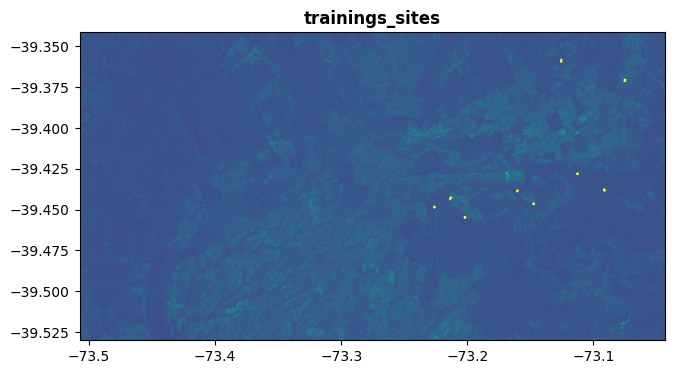

In [35]:
fig, ax1 = plt.subplots(figsize =(10,4))
show(full_dataset, ax = ax1, title = "trainings_sites") # Si cambbios a read se transforma en un array y seguramente cambia la forma de sobrepoenr las capas.
training_sites.plot(ax = ax1, facecolor = "White", edgecolor = "Yellow")
plt.show()


In [36]:
## Extraemos las geometrias de los poligonos
geoms = training_sites.geometry.values

In [37]:
# Lets grab a single shapely geometry to check 
geometry = geoms[0]
print(type(geometry))
print(geometry)

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((-73.20228317899202 -39.45427231205459, -73.20224826902074 -39.45507524139381, -73.20150352296697 -39.45509851470799, -73.20143370302443 -39.45430722202587, -73.20228317899202 -39.45427231205459))


In [38]:
# transform to GeoJSON format
# This allows us to easily pass the geometry 
# data to other functions that require it in string format. 
from shapely.geometry import mapping
feature = [mapping(geometry)]
print(type(feature))
print(feature)

<class 'list'>
[{'type': 'Polygon', 'coordinates': (((-73.20228317899202, -39.45427231205459), (-73.20224826902074, -39.45507524139381), (-73.20150352296697, -39.45509851470799), (-73.20143370302443, -39.45430722202587), (-73.20228317899202, -39.45427231205459)),)}]


In [40]:
X = np.array([], dtype=np.int8).reshape(0,7) # pixels for training
y = np.array([], dtype=np.string_) # labels for training # Eventualmente esto se puede modificar eventualmente para tener un campo numerico

In [43]:
with rasterio.open(r'C:\Users\CRISTIAN\OneDrive - Universidad de Alcala\Classificaciones\clipped_image_7b_ord.tif') as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]
        
        # the mask function returs an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop = True)
        # eliminate all the pixels with 0 values for all 8 bands - AKa not actually part of the shapefile
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y,[training_sites["class"][index]] * out_image_reshaped.shape[0])
        # stack the pizels onto the pixel array
        X = np.vstack((X,out_image_reshaped))

In [52]:
X.s

(118, 7)

In [50]:
len(X[:,0]) # Banda 1

118

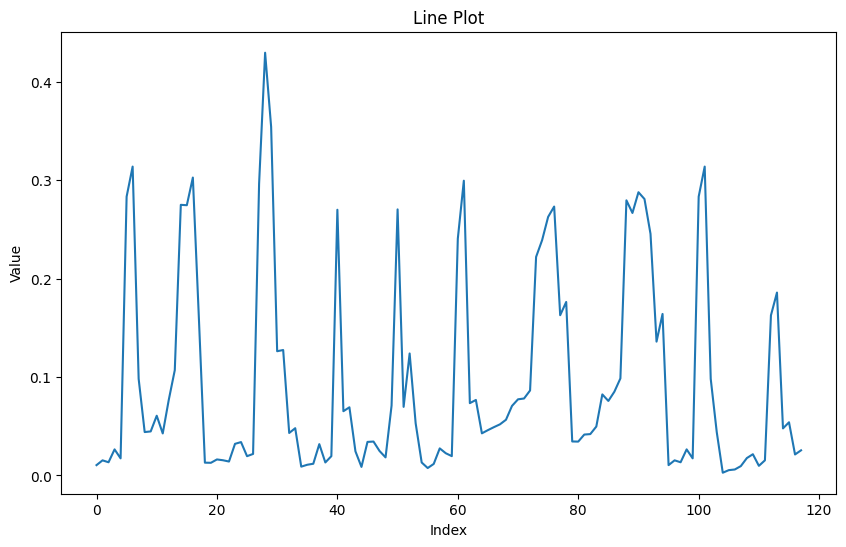

In [57]:
plt.figure(figsize=(10,6))
plt.plot(X[:,1])
plt.title('Line Plot')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

In [59]:
import pandas as pd
df = pd.DataFrame(X)

In [63]:
df.shape

(118, 7)

In [65]:
arr = df.to_numpy()
arr.shape

In [69]:
arr1 = df.values
arr1.shape

(118, 7)

In [75]:
df

,0,1,2,3,4,5,6
0,0.013758,0.012905,0.010457,0.013634,0.012341,0.012135,0.012094
1,0.012204,0.013097,0.015311,0.013524,0.010911,0.014404,0.014156
2,0.013221,0.013221,0.013372,0.014555,0.031096,0.028167,0.020014
3,0.029350,0.027810,0.026449,0.025844,0.026311,0.029694,0.019106
4,0.016700,0.011502,0.017333,0.017071,0.015971,0.015545,0.015957
...,...,...,...,...,...,...,...
113,0.211826,0.156015,0.185729,0.251454,0.219155,0.330475,0.250312
114,0.047858,0.064179,0.047761,0.056932,0.051391,0.061058,0.047830
115,0.060480,0.041134,0.053990,0.074821,0.069500,0.106859,0.090606
116,0.019354,0.025211,0.021292,0.023245,0.020344,0.025046,0.019574


In [76]:
df_y

,0
0,Grassland
1,Grassland
2,Grassland
3,Grassland
4,Grassland
...,...
113,Native_Forest
114,Native_Forest
115,Native_Forest
116,Native_Forest


In [124]:
df_y = pd.DataFrame(y, columns=  ['Categoria']
                    )

In [125]:
df_y

,Categoria
0,Grassland
1,Grassland
2,Grassland
3,Grassland
4,Grassland
...,...
113,Native_Forest
114,Native_Forest
115,Native_Forest
116,Native_Forest


In [126]:
sitios_entrenamiento = df.join(df_y)

In [129]:
sitios_entrenamiento.rename(columns = {0:'b1',1:'b2',2:'b3',3:'b4',4:'b5',5:'b6',6:'b7'
                                       }, inplace = True)

In [131]:
sitios_entrenamiento

,b1,b2,b3,b4,b5,b6,b7,Categoria
0,0.013758,0.012905,0.010457,0.013634,0.012341,0.012135,0.012094,Grassland
1,0.012204,0.013097,0.015311,0.013524,0.010911,0.014404,0.014156,Grassland
2,0.013221,0.013221,0.013372,0.014555,0.031096,0.028167,0.020014,Grassland
3,0.029350,0.027810,0.026449,0.025844,0.026311,0.029694,0.019106,Grassland
4,0.016700,0.011502,0.017333,0.017071,0.015971,0.015545,0.015957,Grassland
...,...,...,...,...,...,...,...,...
113,0.211826,0.156015,0.185729,0.251454,0.219155,0.330475,0.250312,Native_Forest
114,0.047858,0.064179,0.047761,0.056932,0.051391,0.061058,0.047830,Native_Forest
115,0.060480,0.041134,0.053990,0.074821,0.069500,0.106859,0.090606,Native_Forest
116,0.019354,0.025211,0.021292,0.023245,0.020344,0.025046,0.019574,Native_Forest


In [142]:
sitios_entrenamiento.iloc[:,:-1].describe()

,b1,b2,b3,b4,b5,b6,b7
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,0.085844,0.096027,0.095739,0.090496,0.092418,0.093363,0.089402
std,0.095579,0.104206,0.103309,0.094956,0.099378,0.098553,0.092462
min,0.003844,0.003376,0.002744,0.003926,0.004655,0.003692,0.004146
25%,0.017401,0.017955,0.019550,0.017061,0.020241,0.020846,0.019684
50%,0.039456,0.048483,0.047864,0.049941,0.047541,0.050642,0.047541
75%,0.108247,0.145699,0.133781,0.127009,0.116608,0.126181,0.124345
max,0.413333,0.420799,0.429365,0.429365,0.427990,0.409812,0.413333


In [157]:
X[45,]

array([0.03112375, 0.01676875, 0.03403875, 0.0119975 , 0.011365  ,
       0.01247875, 0.01099375])

In [144]:
sitios_entrenamiento.isna().sum()

b1           0
b2           0
b3           0
b4           0
b5           0
b6           0
b7           0
Categoria    0
dtype: int64

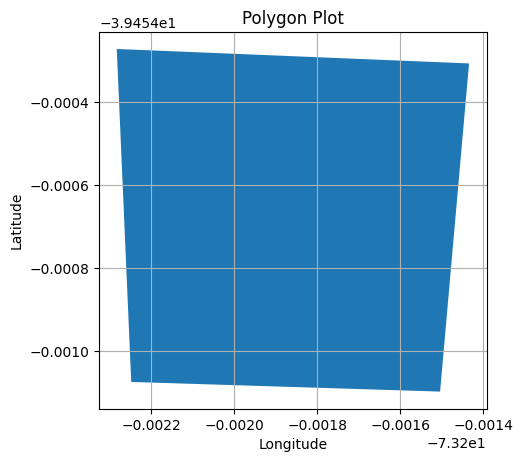

In [148]:
 #Coordinates of the polygon
 from shapely.geometry import Polygon
coordinates = [
    (
        (-73.20228317899202, -39.45427231205459),
        (-73.20224826902074, -39.45507524139381),
        (-73.20150352296697, -39.45509851470799),
        (-73.20143370302443, -39.45430722202587),
        (-73.20228317899202, -39.45427231205459)
    )
]

# Create a GeoDataFrame with a Polygon
polygon = Polygon(coordinates[0])
gdf = gpd.GeoDataFrame(geometry=[polygon])

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(5, 5))
gdf.plot(ax=ax)
plt.title('Polygon Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()